In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from scipy.interpolate import interp1d


"""
CUIDADO!!
"""
import warnings
warnings.filterwarnings("ignore")

* d para Doente
* s para Saudavel

## Loading Data 

In [2]:
with open("data//doente.txt", "r") as file:
    d_data = file.readlines()
    #Cleaning
    d_data = np.array([list(map(float, row.split())) for row in d_data if row != '\n'])

    
with open("data//normal.txt", "r") as file:
    s_data = file.readlines()
    #Cleaning
    s_data = np.array([list(map(float, row.split())) for row in s_data if row != '\n'])


## Cleaning 

In [3]:
d_data[6,1] = 466 # valor corrigido

## Plotting initial data

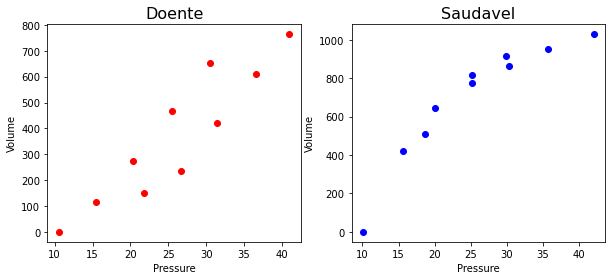

In [4]:
fig, axs = plt.subplots(1,2, figsize = (10,4))

data = [d_data, s_data]
subtitles = ["Doente", "Saudavel"]
colors = ["r","b"]

for ax, d, subtitle, color in zip(axs.flatten(), data, subtitles, colors):
    ax.scatter(d[:,0], d[:,1], c = color)
    ax.set_title(subtitle, fontsize = 16)
    ax.set_ylabel("Volume")
    ax.set_xlabel("Pressure")

## Fitting Sigmoid

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

In [5]:
"""
Esses : na assinatura das funções é para identificar o tipo da variável (não é obrigatório).
Em python não existe o conceito de protected, private e public quanto eu quero indicar que uma função
é private o nome dela começa com _  .
"""
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.legend import Legend

from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

from sklearn.metrics import mean_squared_error


"""
npoint: Number of points to be fitted
estimator: Method to use for optimization
"""

class funcFitter:
    
    def __init__(self, data:np.ndarray, n_point:int=5, estimators:list=["lm"]):
        self.n_point = n_point
        self.estimators = estimators
        self.pressures = data[:,0] ##Selecionar somente as PEEP
        self.volumes = data[:,1] ##Selecionar somente os volumes minimos
        self.pmin = min(self.pressures)
        self.interpolate = False
        
    def _interpolate(self, n_interp_point:int):
        last_point = self.pressures[:self.n_point][-1]
        self.interp_pressures = np.linspace(self.pmin, last_point, n_interp_point, endpoint=True)
        interp_func = interp1d(self.pressures[:self.n_point], self.volumes[:self.n_point], kind=self.interp_method)
        self.interp_volumes = interp_func(self.interp_pressures)
        
    def _get_error(self, func, parameters):
        
        hat_volumes = func(self.pressures, *parameters)
        
        return mean_squared_error(np.array(self.volumes), np.array(hat_volumes))
        
    def _make_fit_report(self, funcs:list, estimators:list, n_interp_point:int):
        """
        Ta feia a função ... pensar em um jeito de ficar bonito.
        """
        interp_data = []
        interp_run = []
        data = []
        run = []
        
        cols = ["function", "function_name", "estimator", "error", "param"]
        interp_cols = ["function", "function_name", "estimator", "error", "param", "interp_point", "interp_pressure", "interp_volume"]
        
        for func in funcs:
            for estimator in self.estimators:
                if self.interpolate:
                    for point in range(5, n_interp_point, 5):
                        try:
                            self._interpolate(point)
                            parameters, pcov = curve_fit(func, 
                                                         self.interp_pressures,  
                                                         self.interp_volumes, 
                                                         method=estimator)
                            err = self._get_error(func=func, parameters=parameters)

                            interp_run.append(func)
                            interp_run.append(func.__name__)
                            interp_run.append(estimator)
                            interp_run.append(err)
                            interp_run.append(parameters)
                            interp_run.append(point)
                            interp_run.append(self.interp_pressures)
                            interp_run.append(self.interp_volumes)
                            interp_data.append(interp_run)
                            interp_run = []
                            
                        except Exception as e:
                            pass


                else:
                    try:
                        parameters, pcov = curve_fit(func, 
                                                     self.pressures[:self.n_point],  
                                                     self.volumes[:self.n_point], 
                                                     method=estimator)
                        err = self._get_error(func=func, parameters=parameters)

                        run.append(func)
                        run.append(func.__name__)
                        run.append(estimator)
                        run.append(err)
                        run.append(parameters)
                        data.append(run)
                        run = []
                        
                    except Exception as e:
                        pass
               
    
        if self.interpolate:             
            return pd.DataFrame(interp_data, columns=interp_cols)    
        else:
            return pd.DataFrame(data, columns=cols)    

    def fit(self, funcs, interpolate:bool=False, n_interp_point:int=30, interp_method:str="linear"):
        
        self.n_interp_point = n_interp_point
        self.interp_method = interp_method           
        self.interpolate = interpolate

        return self._make_fit_report(funcs=funcs, estimators=self.estimators, n_interp_point=n_interp_point)
   
    def summary(self):
        print(f'Interpolated: ({self.interpolate})')
        print(f'Data pressure interval: ({self.pressures[0]}, {self.pressures[-1]})')
        print(f'Data volume interval:   ({self.volumes[0]}, {self.volumes[-1]})')
        print('Sigmoid parameters: a=%5.2f, b=%5.2f, c=%5.2f, d=%5.2f' % tuple(self.parameters))

    def get_parameters(self):
        try:
            if self.interpolate:
                return [self.n_point, self.n_interp_point, self.interp_method, self.estimator, self.parameters[1]]
            else:
                return [self.n_point, self.interp_method, self.estimator, self.parameters[1]]
            
        except Exception as e:
            print("Fit before getting parameters:\n{e}")
        
    def make_plot(self, df:pd.DataFrame, n_best = 6):
        if len(df) == 0:
            print("Does not exist available plot")
            return None
        n_col = 2
        n_row = int(np.ceil(n_best/n_col))
        
        df.reset_index(drop = True, inplace = True)
        best_fits= df["error"].nsmallest(n_best).index
        
        fig, axs = plt.subplots(n_row, n_col, figsize = (5*n_col,4*n_row))

        for row, ax in zip(df.iloc[best_fits].iterrows(), axs.flatten()):
            new_pressures = range(0,100,7)

            _, data = row
            new_pressures = range(0,100,7)
            ax.set_title(f"Model: {data['function_name']} Error: {round(data['error'], 2)}")
            ax.scatter(self.pressures, self.volumes, c = 'r', label = "Original")
            if self.interpolate:
                ax.scatter(data["interp_pressure"], data["interp_volume"], c = 'k', marker = '.', label = "Interpolated")
                ax.text(0.98, 0.6, f"n interp points: {data['interp_point']}",
                horizontalalignment='right',
                verticalalignment='bottom',
                transform = ax.transAxes)
            ax.scatter(new_pressures, data["function"](new_pressures, *data["param"]), c = 'g', marker = '+', label = "Fit")
            ax.set_xlabel('Pressure')
            ax.set_ylabel('Volume')
            ax.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
            
            ax.text(0.98, 0.5, f"Estimator: {data['estimator']}",
                    horizontalalignment='right',
                    verticalalignment='bottom',
                    transform = ax.transAxes)
            
        plt.tight_layout()
        plt.show()

### Parameters

In [6]:
def sigmoid(x, a, b, c, d):
    return a + b/(1 + np.exp(-(x-c)/d))

def exponential(x, a, b, c, d):
    return a - np.exp(-(x-c)/d)

estimators = ["lm", "trf", "dogbox"]
funcs = [sigmoid, exponential]

### Injuried

In [7]:
#Interpolando
fitter = funcFitter(d_data[0::2, :], n_point = 3, estimators = estimators)
injuried = fitter.fit(funcs=funcs, interpolate=True, n_interp_point=100, interp_method="linear")
injuried.head(2)

,function,function_name,estimator,error,param,interp_point,interp_pressure,interp_volume
0,<function sigmoid at 0x00000214DCCD10D0>,sigmoid,lm,82.741265,"[-183.8841085954966, 1181.0232960674384, 24.01...",5,"[10.546184739, 13.0040160643, 15.4618473895999...","[-0.324999419644, 56.642755995178, 113.6105114..."
1,<function sigmoid at 0x00000214DCCD10D0>,sigmoid,lm,46.713111,"[-188.7779022559329, 1222.3314770453546, 24.41...",10,"[10.546184739, 11.63855421691111, 12.730923694...","[-0.324999419644, 24.99400298694355, 50.313005..."


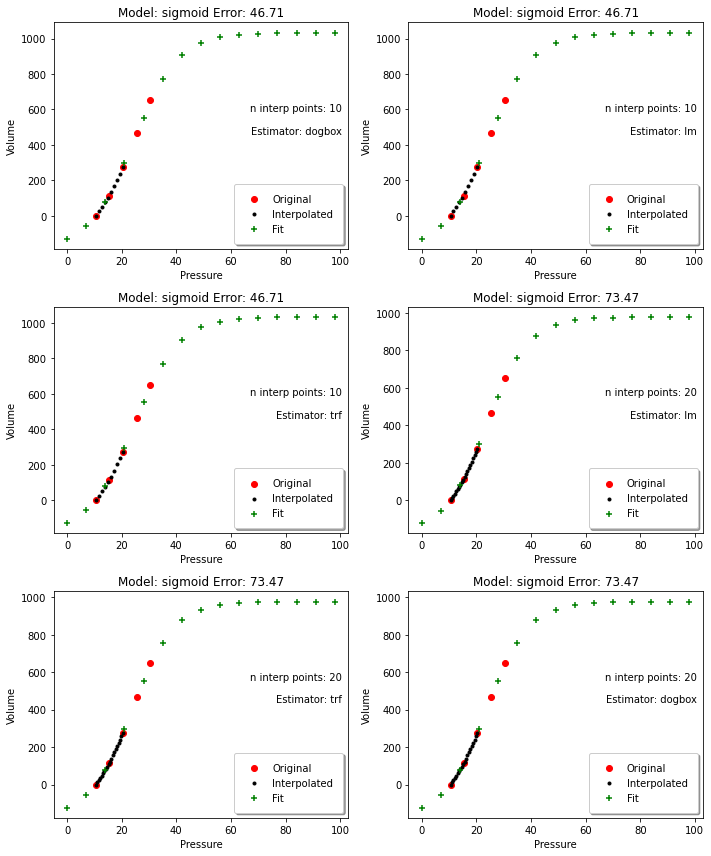

In [8]:
fitter.make_plot(df = injuried, n_best = 6)

In [9]:
#Sem Interpolação
fitter = funcFitter(d_data[0::2, :], n_point = 3, estimators = estimators)
injuried = fitter.fit(funcs=funcs, interpolate=False)
injuried.head(2)

,function,function_name,estimator,error,param
0,<function sigmoid at 0x00000214DCCD10D0>,sigmoid,trf,35975.987753,"[-0.32500047329926873, 274.11379902508367, 15...."
1,<function sigmoid at 0x00000214DCCD10D0>,sigmoid,dogbox,35975.988151,"[-0.32499941964401574, 274.1137962256441, 15.5..."


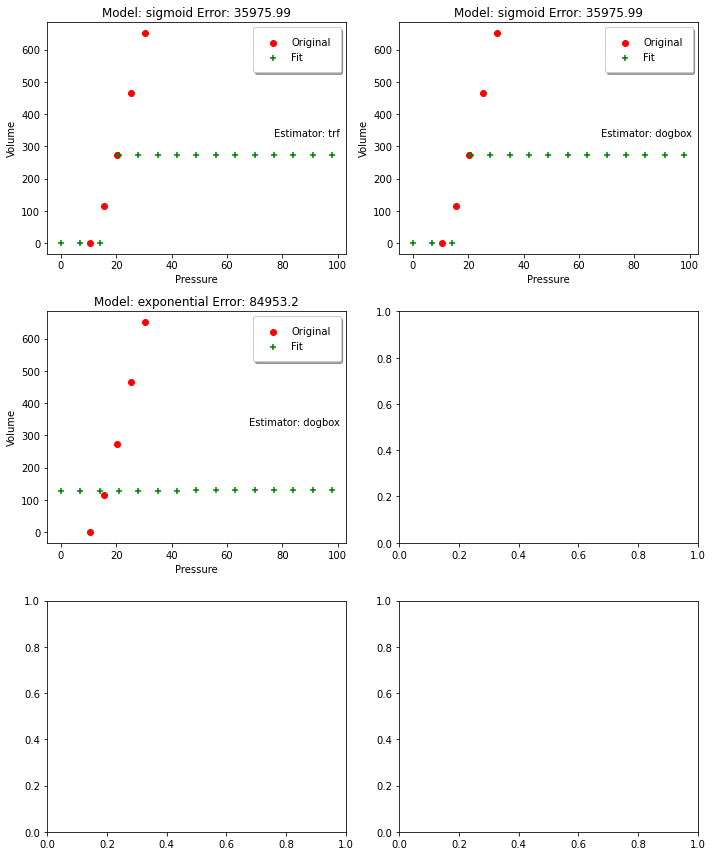

In [10]:
fitter.make_plot(df = injuried, n_best = 6)

### Healthy

In [11]:
#Interpolando
fitter = funcFitter(s_data, n_point = 6, estimators = estimators)
healthy = fitter.fit(funcs=funcs, interpolate=True, n_interp_point=100, interp_method="linear")

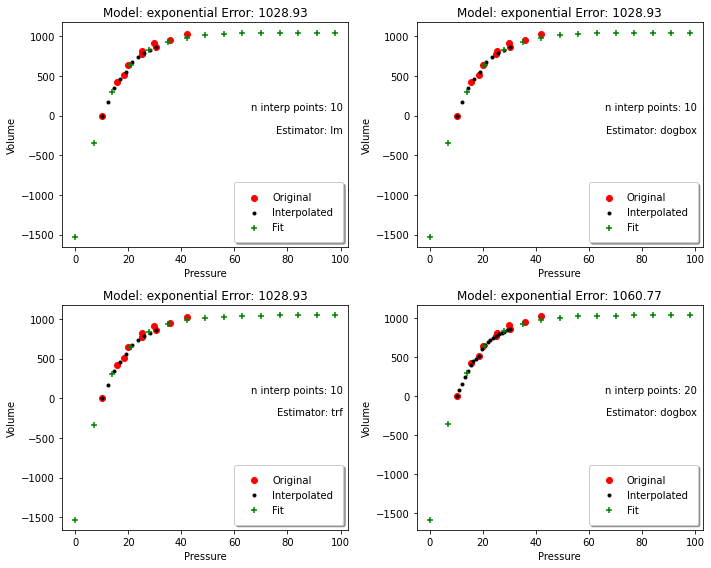

In [12]:
fitter.make_plot(df = healthy, n_best = 4)

In [13]:
#Sem Interpolação
fitter = funcFitter(s_data, n_point = 6, estimators = estimators)
healthy = fitter.fit(funcs=funcs, interpolate=False)

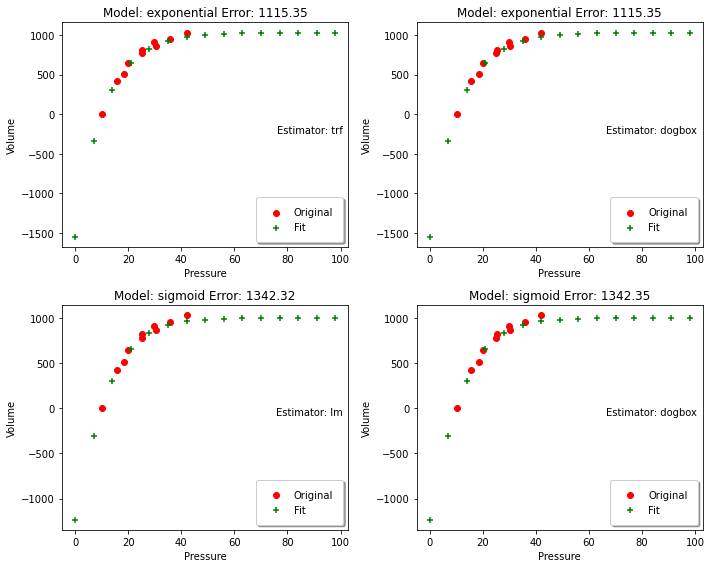

In [14]:
fitter.make_plot(df = healthy, n_best = 4)